In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import json
import lime
import lime.lime_tabular
from joblib import dump, load

In [8]:
X_train = pd.read_csv('dati/X_train.csv')
X_test = pd.read_csv('dati/X_test.csv')
y_test = pd.read_csv('dati/y_test.csv')
print("X_train:", X_train.shape)
print("X_test:",X_test.shape)

X_train: (1132654, 61)
X_test: (932294, 61)


In [6]:
input_dim = 61  # Numero di features per ciascun record
input_layer = tf.keras.Input(shape=(input_dim,))

encoder1 = tf.keras.layers.Dense(61, activation='relu')(input_layer)
encoder2 = tf.keras.layers.Dense(30, activation='relu')(encoder1)
encoder3 = tf.keras.layers.Dense(15, activation='relu')(encoder2)

decoder1 = tf.keras.layers.Dense(15, activation='relu')(encoder3)
decoder2 = tf.keras.layers.Dense(30, activation='relu')(decoder1)
decoder3 = tf.keras.layers.Dense(61, activation='relu')(decoder2)

output_layer = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoder3)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=output_layer)
optimizer = tf.keras.optimizers.Adam()


autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Stampa dell'architettura del modello
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 61)             │         3,782 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 61)             │         1,891 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 61)             │         3,782 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,500 (48.83 KB)

 Trainable params: 12,500 (48.83 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Addestramento del modello
autoencoder.fit(X_train, X_train, epochs=30, batch_size=256, shuffle=True)

Epoch 1/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0334
Epoch 2/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0183
Epoch 3/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0178
Epoch 4/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0178
Epoch 5/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0176
Epoch 6/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0173
Epoch 7/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0170
Epoch 8/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0160
Epoch 9/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0158
Epoch 10/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0157
Epoch 11/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0157
Epoch 12/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0157
Epoch 13/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0157
Epoch 14/30
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0157
Epoch 15/30
442

In [8]:
# Salvataggio del modello
autoencoder.save("autoencoder.keras")

In [5]:
autoencoder=tf.keras.models.load_model('autoencoder.keras')

In [10]:
# Calcola l'errore di ricostruzione
reconstructions = autoencoder.predict(X_test)
loss = np.mean(np.abs(reconstructions - X_test), axis=1)

29135/29135 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step


In [11]:
# Calcola la curva precision-recall
def curva_precision_recall(y_test, loss):
    # Trova il threshold ottimale che massim
    precision, recall, thresholds_pr = precision_recall_curve(y_test, loss)
    auc_pr = auc(recall, precision)

    # Trova il threshold ottimale che massimizza l'F1-score
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold_pr = thresholds_pr[np.argmax(f1_scores)]

    print("AUC-PR:", auc_pr)
    print("Best Threshold (Precision-Recall):", best_threshold_pr)

    # Grafico della curva Precision-Recall
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve (AUC-PR = %0.2f)' % auc_pr, color='b')
    plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], color='red', marker='o', label='Best F1-Score')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()
    return best_threshold_pr

In [12]:
# Calcola la curva ROC
def curva_roc(y_test,loss):
    fpr, tpr, thresholds_roc = roc_curve(y_test, loss)

    # Calcola l'AUC-ROC
    roc_auc = auc(fpr, tpr)

    # Trova il miglior threshold utilizzando l'AUC-ROC
    optimal_threshold_index = np.argmax(tpr - fpr) #tpr-fpr è l'indice di Youden
    best_threshold_roc = thresholds_roc[optimal_threshold_index]

    print("AUC-ROC:", roc_auc)
    print("Best Threshold (ROC):", best_threshold_roc)

    # Grafico della curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (AUC-ROC = %0.2f)' % roc_auc, color='b')
    plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='red', marker='o', label='Optimal Threshold')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    return best_threshold_roc

In [13]:
def detect_anomaly(new_data, autoencoder, threshold):
    reconstructions = autoencoder.predict(new_data)
    loss = np.mean(np.abs(reconstructions - new_data), axis=1)
    anomalies = loss >= threshold
    return anomalies

AUC-ROC: 0.9200312583045105
Best Threshold (ROC): 0.049180345336821335


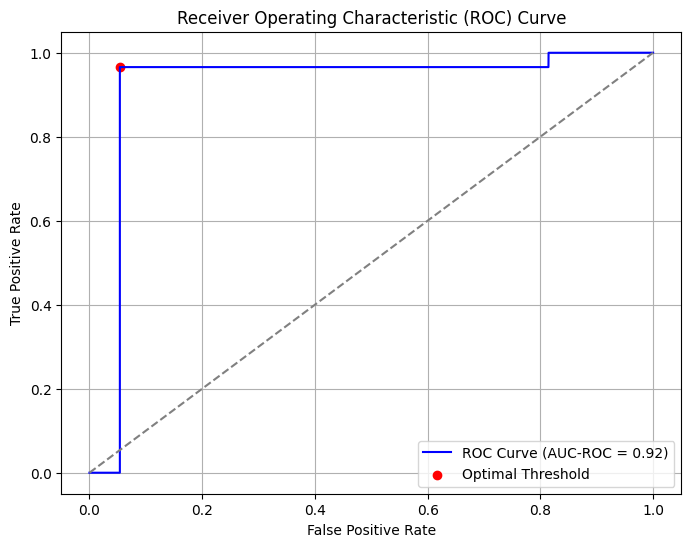

29135/29135 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
AUC-PR: 0.39902368463317084
Best Threshold (Precision-Recall): 0.049180345390795084


C:\Users\fraia\AppData\Local\Temp\ipykernel_17352\3924243696.py:8: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


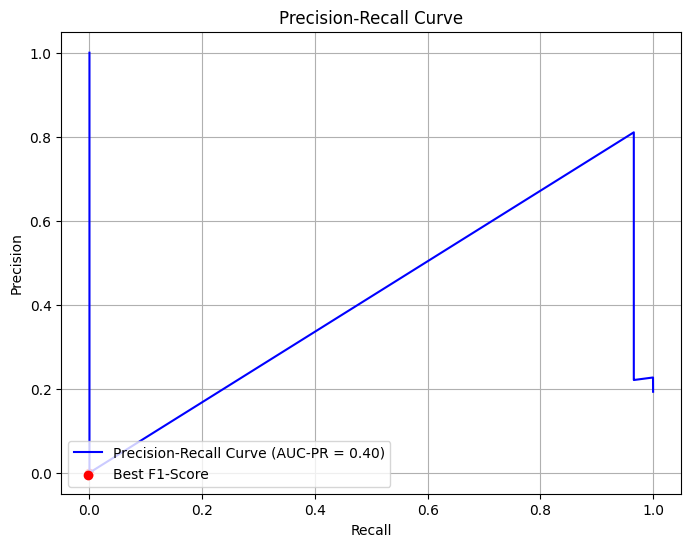

29135/29135 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step


In [14]:
threshold_roc=curva_roc(y_test,loss)
predicted_labels_roc = detect_anomaly(X_test, autoencoder, threshold_roc)

threshold_pr = curva_precision_recall(y_test, loss)
predicted_labels_pr = detect_anomaly(X_test, autoencoder, threshold_pr)

In [15]:
# Conversione delle etichette test in un array booleano dove True indica un'anomalia
real_labels = y_test.to_numpy().astype(bool).flatten()

# Calcolo della precisione testuale con roc
print(classification_report(real_labels, predicted_labels_roc))
print("\nAccuracy con roc:", accuracy_score(real_labels, predicted_labels_roc))

# Calcolo della precisione testuale con pr
print(classification_report(real_labels, predicted_labels_pr))
print("\nAccuracy con pr:", accuracy_score(real_labels, predicted_labels_pr))

              precision    recall  f1-score   support

       False       0.99      0.95      0.97    752556
        True       0.81      0.97      0.88    179738

    accuracy                           0.95    932294
   macro avg       0.90      0.96      0.92    932294
weighted avg       0.96      0.95      0.95    932294


Accuracy con roc: 0.9498602372213057
              precision    recall  f1-score   support

       False       0.80      0.95      0.87    752556
        True       0.00      0.00      0.00    179738

    accuracy                           0.76    932294
   macro avg       0.40      0.47      0.43    932294
weighted avg       0.64      0.76      0.70    932294


Accuracy con pr: 0.7636678987529685


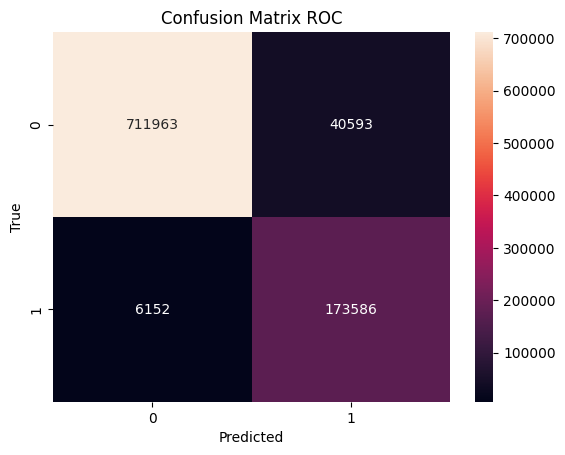


Accuracy con roc: 0.9498602372213057


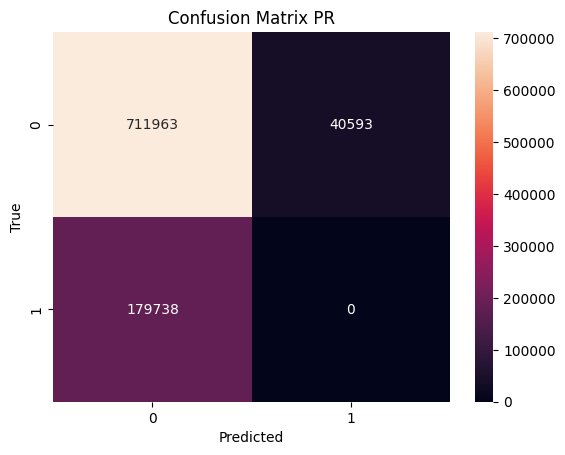


Accuracy con pr: 0.7636678987529685


In [16]:
#confusion matrix con roc
cm = confusion_matrix(real_labels, predicted_labels_roc)
sns.heatmap(cm, annot=True, fmt="d")    
plt.title("Confusion Matrix ROC")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print("\nAccuracy con roc:", accuracy_score(real_labels, predicted_labels_roc))

#confusion matrix con pr
cm = confusion_matrix(real_labels, predicted_labels_pr)
sns.heatmap(cm, annot=True, fmt="d")    
plt.title("Confusion Matrix PR")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print("\nAccuracy con pr:", accuracy_score(real_labels, predicted_labels_pr))

29135/29135 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step


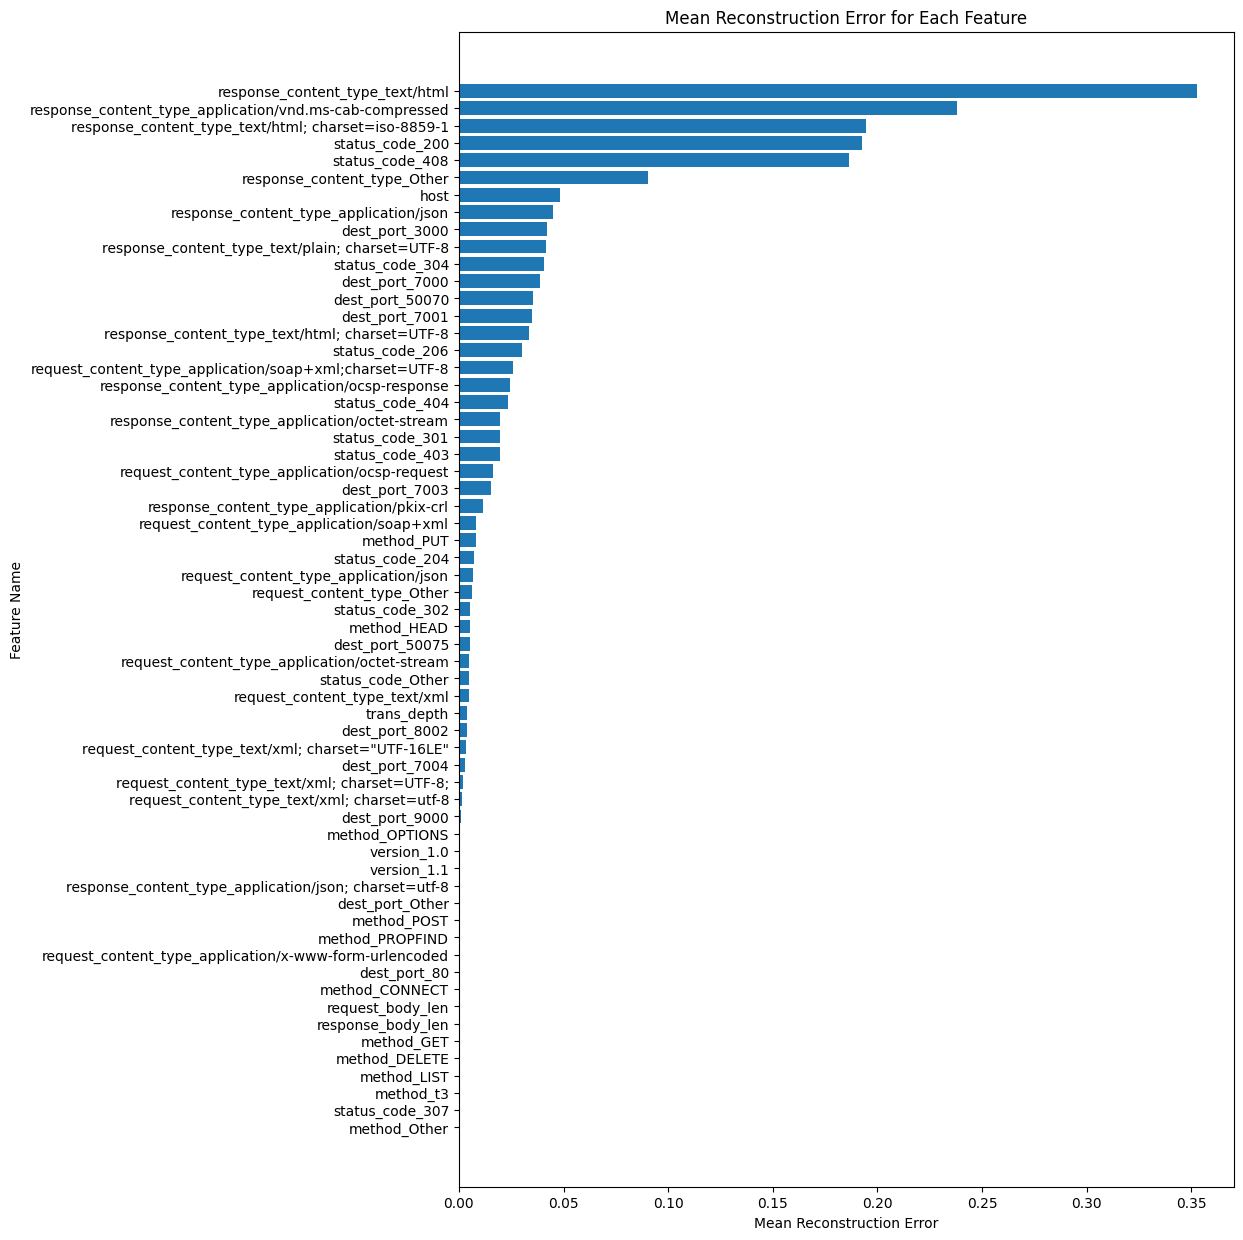

Features ordinate per errore di ricostruzione (dalla più influente):
Feature 'response_content_type_text/html': Mean reconstruction error = 0.3526666480745344
Feature 'response_content_type_application/vnd.ms-cab-compressed': Mean reconstruction error = 0.2381453157872601
Feature 'response_content_type_text/html; charset=iso-8859-1': Mean reconstruction error = 0.19463388158670983
Feature 'status_code_200': Mean reconstruction error = 0.19275747431584117
Feature 'status_code_408': Mean reconstruction error = 0.1861977015834061
Feature 'response_content_type_Other': Mean reconstruction error = 0.09051543826303719
Feature 'host': Mean reconstruction error = 0.04841923276838735
Feature 'response_content_type_application/json': Mean reconstruction error = 0.045065183300546895
Feature 'dest_port_3000': Mean reconstruction error = 0.04215408444117413
Feature 'response_content_type_text/plain; charset=UTF-8': Mean reconstruction error = 0.04156843227566699
Feature 'status_code_304': Mean reco

In [7]:
#FEATURES
reconstructions = autoencoder.predict(X_test)

feature_names = X_test.columns

reconstruction_errors = np.abs(reconstructions - X_test) # Calcola l'errore di ricostruzione per ciascuna feature

mean_feature_error = np.mean(reconstruction_errors, axis=0) # Media dell'errore di ricostruzione su tutti i record per ciascuna feature

feature_error_dict = dict(zip(feature_names, mean_feature_error))

sorted_feature_error = sorted(feature_error_dict.items(), key=lambda x: x[1], reverse=True) # Ordina le feature in base all'errore medio di ricostruzione

plt.figure(figsize=(10, 15))
plt.barh([x[0] for x in sorted_feature_error], [x[1] for x in sorted_feature_error])
plt.gca().invert_yaxis() 
plt.xlabel('Mean Reconstruction Error')
plt.ylabel('Feature Name')
plt.title('Mean Reconstruction Error for Each Feature')
plt.show()

print("Features ordinate per errore di ricostruzione (dalla più influente):")
for feature, error in sorted_feature_error:
    print(f"Feature '{feature}': Mean reconstruction error = {error}")
